In [1]:


import sys
import os
# sys.path.append('/home/beinhaud/diplomka/mcs-source/evaluation_tools')
sys.path.append('/home/david/source/diplomka/evaluation_tools')
sys.path.append('/home/david/source/diplomka/results_analysis_tools')
from typing import List, Dict, Any, Tuple, Union

from evaluation_tools.plugins.predictions_analyzer import PredictionsAnalyzer
from evaluation_tools.plugins.wandb_processor import WandbProcessor
from evaluation_tools.fields.experiment_parameters_fields import WandbExperimentVariants, GridSearchRunVariants, ModelEvaluationRunVariant, AdditionalExperiments
from evaluation_tools.fields.prediction_analysis_fields import (
    BatchSummaryFields,
    EvaluationPairsVariants,
)
from evaluation_tools.fields.dataset_analyzer_fields import AnalysisFields, DatasetVariantField
from evaluation_tools.fields.evaluation_processor_fields import EvaluationProcessorChoices
from nn_model.type_variants import EvaluationFields
import nn_model.globals

import pandas as pd
import numpy as np

from results_analysis_tools.result_analyzer import ResultAnalyzer
from evaluation_tools.fields.dataset_parameters import ALL_TIME_STEP_VARIANTS
from results_analysis_tools.fields.experiment_analyses import (
    PlottingVariants,
    PluginVariants,
)
from results_analysis_tools.results_plotter import ResultsPlotter
from results_analysis_tools.plugins.dataset_results_processor import DatasetResultsProcessor

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

from evaluation_tools.fields.dataset_analyzer_fields import StatisticsFields



In [2]:
PLOTING_DESTINATION = "/home/david/source/diplomka/thesis_plots/"
EVALUATION_RESULTS_BASE = "/analysis_results"
analysis_paths = {
    EvaluationProcessorChoices.FULL_DATASET_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.FULL_DATASET_ANALYSIS.value}/",
    EvaluationProcessorChoices.SUBSET_DATASET_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.SUBSET_DATASET_ANALYSIS.value}/",
    # EvaluationProcessorChoices.WANDB_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.WANDB_ANALYSIS.value}/",
    EvaluationProcessorChoices.PREDICTION_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.PREDICTION_ANALYSIS.value}/",
}
result_analyzer = ResultAnalyzer(analysis_paths)
all_results = result_analyzer.get_all_results



# Synchrony 

Plotting of the synchrony boxplot across different time bin sizes.

Index(['time_step', 'layer', 'statistics_type', 'values'], dtype='object')


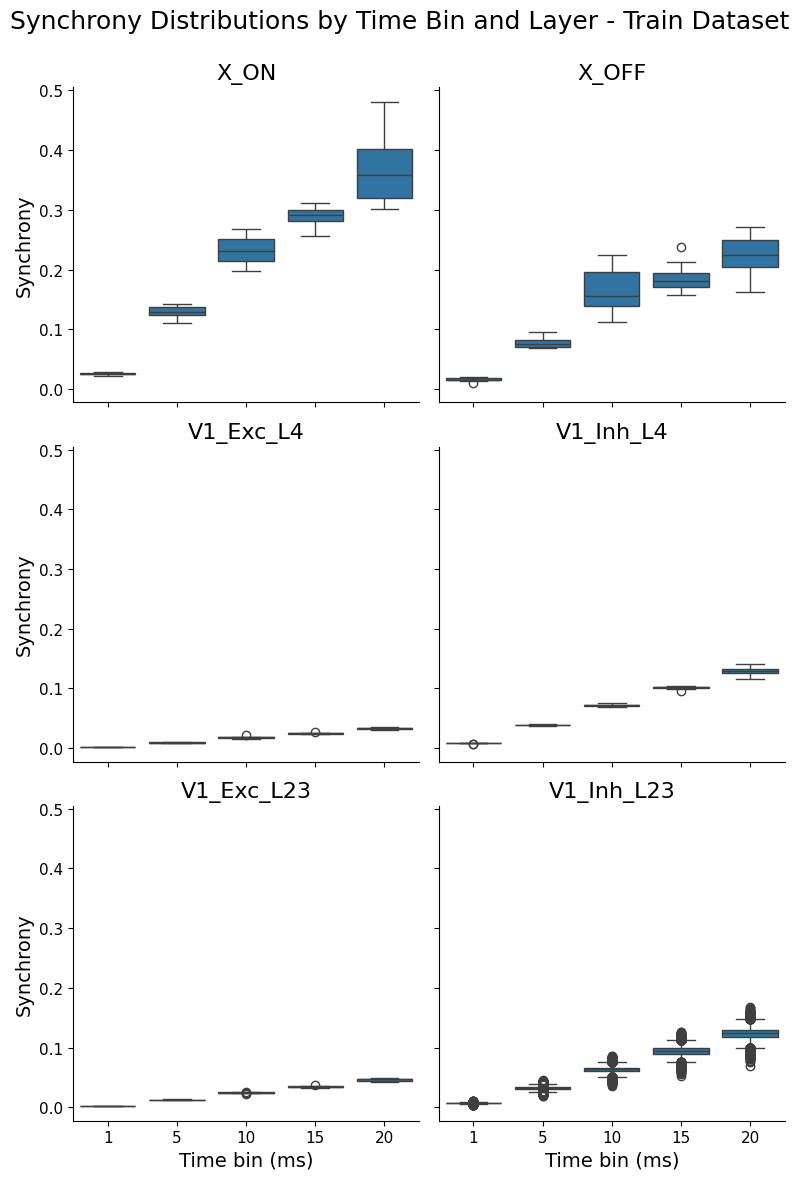

In [3]:
is_test = False
filename = f"synchrony_boxplot_time_bins_{"test" if is_test else "train"}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.SYNCHRONY_TIME_BINS, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.SYNCHRONY_TIME_BINS, save_fig=destination, is_test=is_test)

Index(['time_step', 'layer', 'statistics_type', 'values'], dtype='object')


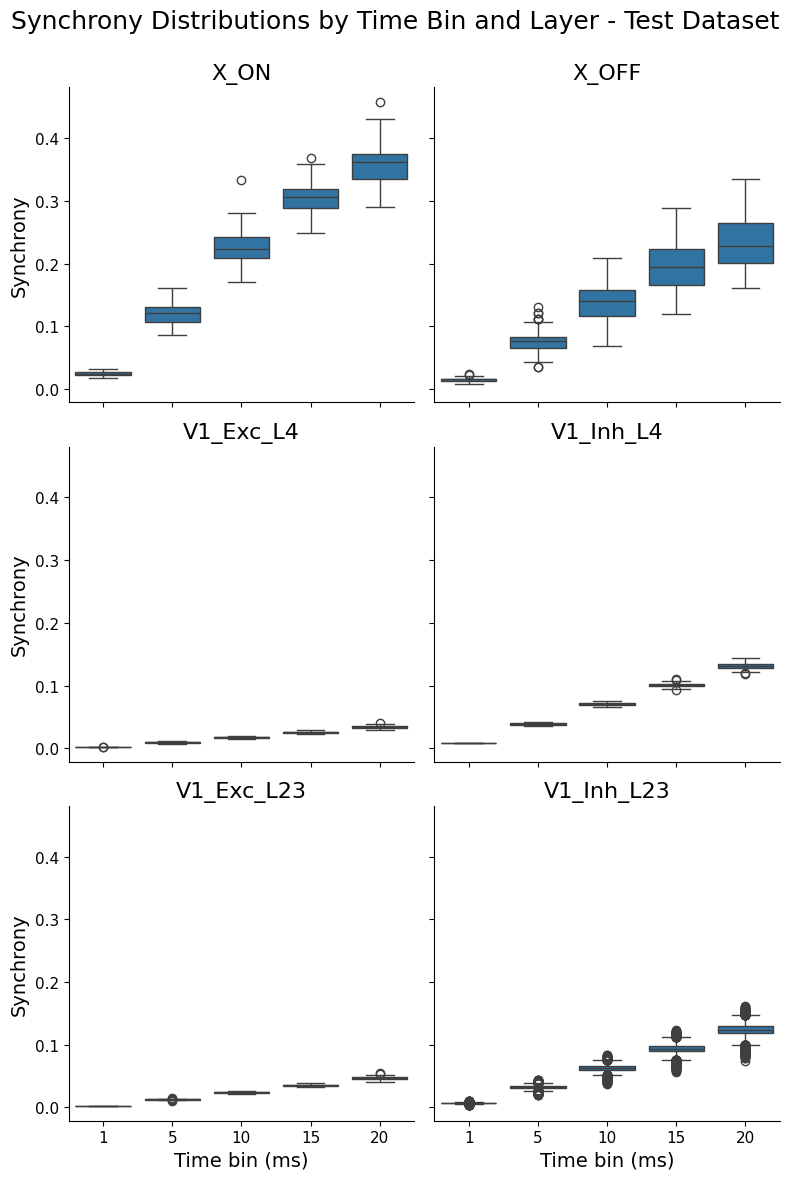

In [4]:
is_test = True
filename = f"synchrony_boxplot_time_bins_{"test" if is_test else "train"}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.SYNCHRONY_TIME_BINS, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.SYNCHRONY_TIME_BINS, save_fig=destination, is_test=is_test)

In [19]:
result_analyzer.get_synchrony_spearman_correlation(is_test=False, return_latex=False)

Index(['time_step', 'layer', 'statistics_type', 'values'], dtype='object')


,layer,r,p
0,All,1.0000,0.0
1,X_ON,0.9751,0.0
2,X_OFF,0.9114,0.0
3,V1_Exc_L4,0.9800,0.0
4,V1_Inh_L4,0.9800,0.0
5,V1_Exc_L23,0.9800,0.0
6,V1_Inh_L23,0.9789,0.0


In [18]:
result_analyzer.get_synchrony_spearman_correlation(is_test=True, return_latex=False)

Index(['time_step', 'layer', 'statistics_type', 'values'], dtype='object')


,layer,r,p
0,All,1.0000,0.0
1,X_ON,0.9606,0.0
2,X_OFF,0.9118,0.0
3,V1_Exc_L4,0.9759,0.0
4,V1_Inh_L4,0.9759,0.0
5,V1_Exc_L23,0.9759,0.0
6,V1_Inh_L23,0.9786,0.0


In [7]:
def function_to_process(row: pd.Series) -> Dict[str, Any]:
    return {
        "statistics_type": row["statistics_type"],
        "values": row["values"],
    }
    

In [8]:
separate_train_experiment = DatasetResultsProcessor.get_dataset_type(DatasetResultsProcessor.get_analysis_type(DatasetResultsProcessor.get_full_dataset_variant(all_results), AnalysisFields.SEPARATE_EXPERIMENT_ANALYSIS), is_test=False)

data = DatasetResultsProcessor.reformat_dataset_dataframe(separate_train_experiment, function_to_process)
data = data[data["statistics_type"] == StatisticsFields.SYNCHRONY]
# data["values"][24]
data.columns

Index(['time_step', 'layer', 'statistics_type', 'values'], dtype='object')

In [9]:
import pandas as pd
import numpy as np

# Build long-form DataFrame from exploded 2D synchrony arrays
long_rows = []

df = data.copy()

for _, row in df.iterrows():
    ts = row['time_step']
    layer = row['layer']
    sync_values = row['values'].flatten()  # flatten 2D array to 1D

    for val in sync_values:
        long_rows.append({'time_step': ts, 'layer': layer, 'synchrony': val})

long_df = pd.DataFrame(long_rows)


In [10]:
from scipy.stats import spearmanr

grouped = long_df.groupby('time_step')['synchrony'].mean().reset_index()
r, p = spearmanr(grouped['time_step'], grouped['synchrony'])
print(f"Spearman correlation = {r:.2f}, p-value = {p:.4f}")


for layer in long_df['layer'].unique():
    sub = long_df[long_df['layer'] == layer]
    r, p = spearmanr(sub['time_step'], sub['synchrony'])
    print(f"{layer}: Spearman r = {r:.2f}, p = {p:.4f}")

Spearman correlation = 1.00, p-value = 0.0000
X_ON: Spearman r = 0.98, p = 0.0000
X_OFF: Spearman r = 0.91, p = 0.0000
V1_Exc_L4: Spearman r = 0.98, p = 0.0000
V1_Inh_L4: Spearman r = 0.98, p = 0.0000
V1_Exc_L23: Spearman r = 0.98, p = 0.0000
V1_Inh_L23: Spearman r = 0.98, p = 0.0000


# Time Bin Spike Counts
This part of code shows how to plot the distribution of spike counts across all time bins and how to write the exact ratios.

In [11]:
counts = result_analyzer.get_mean_spike_counts(False)

In [12]:
# result_analyzer = ResultAnalyzer(analysis_paths)
counts_test = result_analyzer.get_mean_spike_counts(is_test=True)

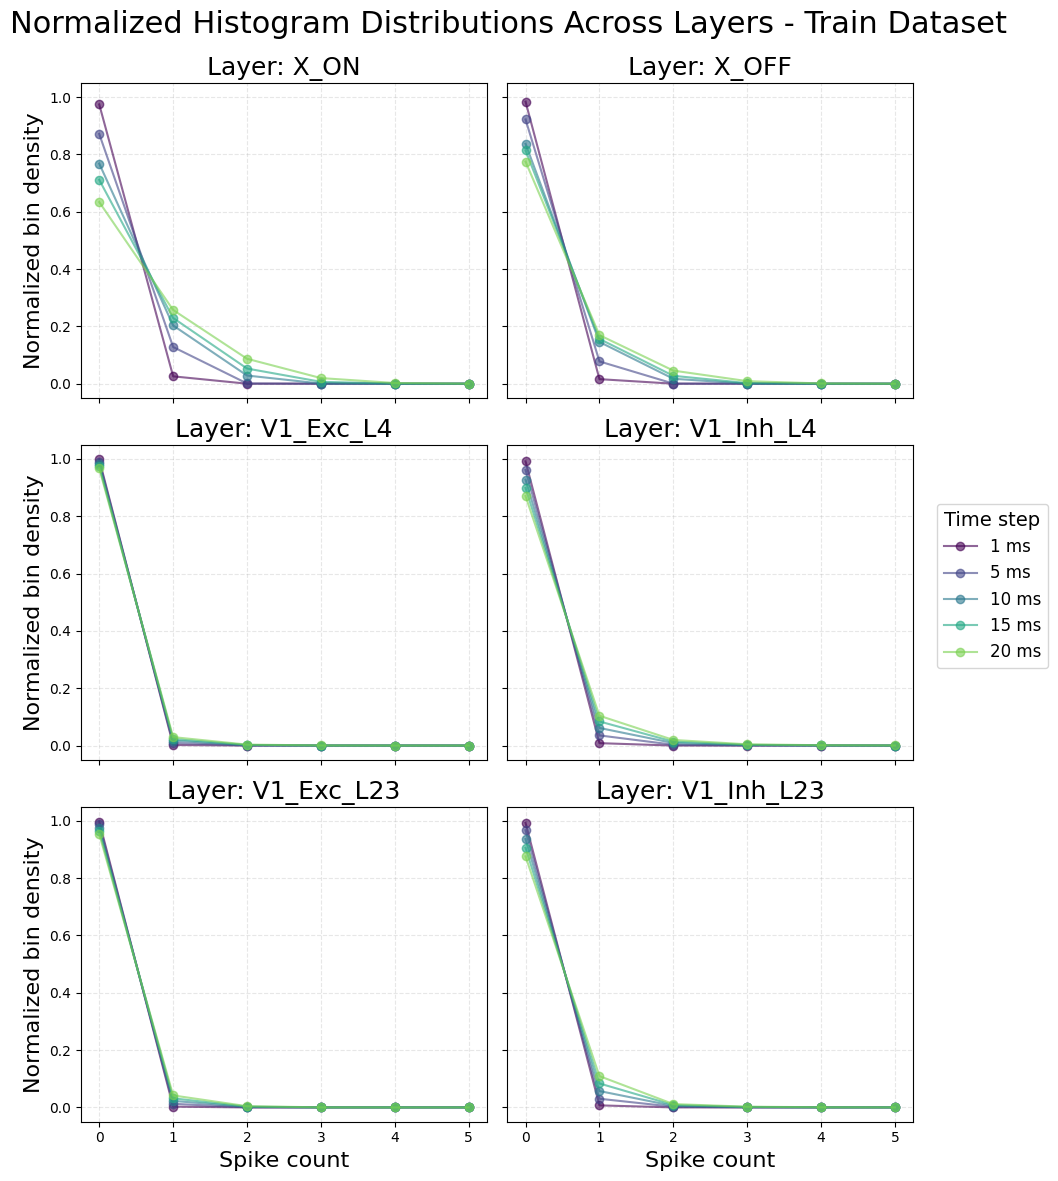

In [13]:
is_test = False
filename = f"time_step_counts_{"test" if is_test else "train"}.pdf"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.TIME_BIN_COUNT_RATIO, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.TIME_BIN_COUNT_RATIO, is_test=is_test, save_fig=f"{PLOTING_DESTINATION}{filename}")

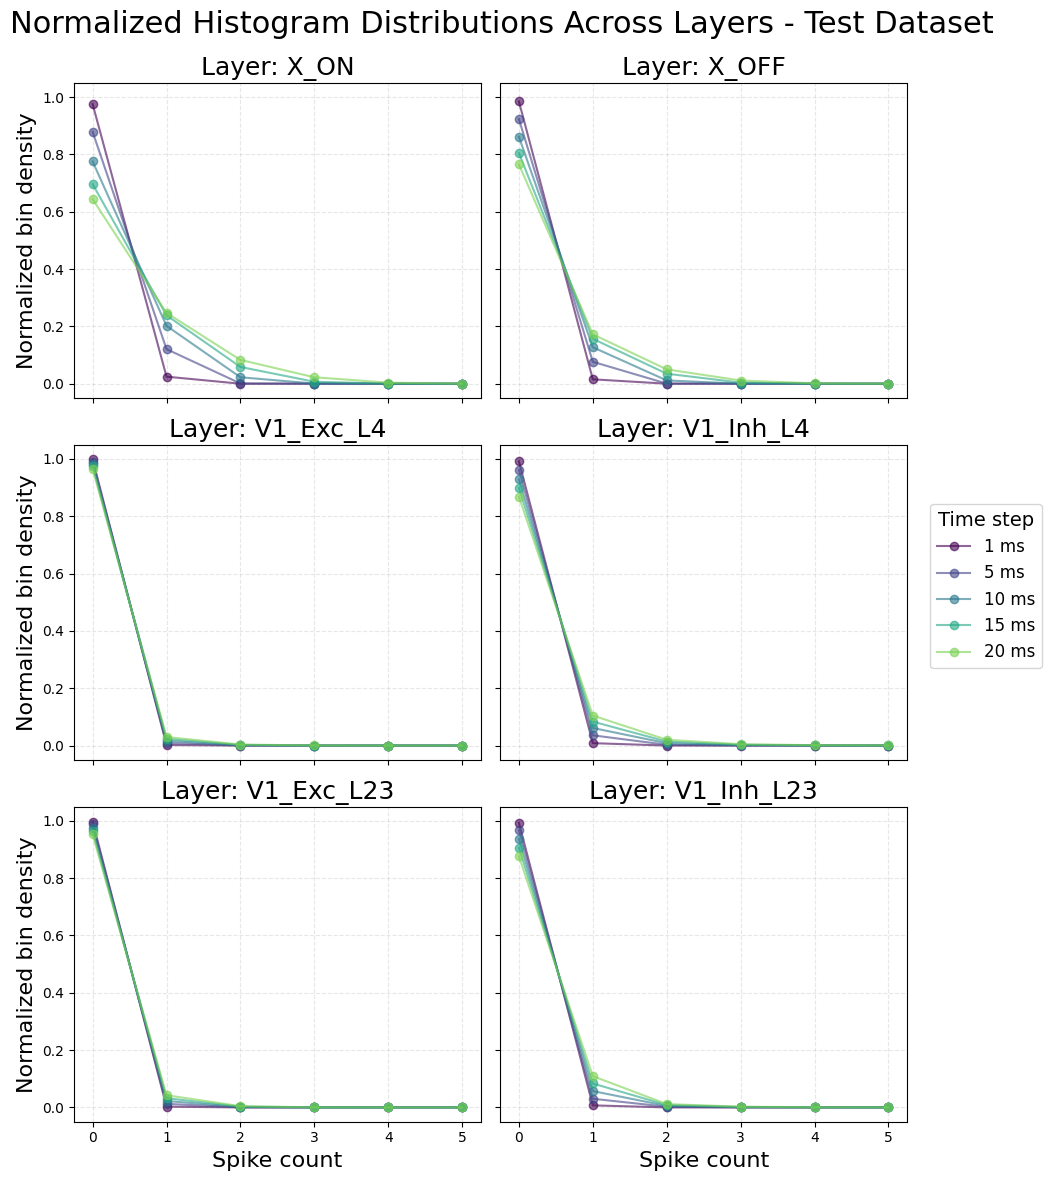

In [14]:
is_test = True
filename = f"time_step_counts_{"test" if is_test else "train"}.pdf"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.TIME_BIN_COUNT_RATIO, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.TIME_BIN_COUNT_RATIO, is_test=is_test, save_fig=f"{PLOTING_DESTINATION}{filename}")

# Temporal Distribution of Spikes

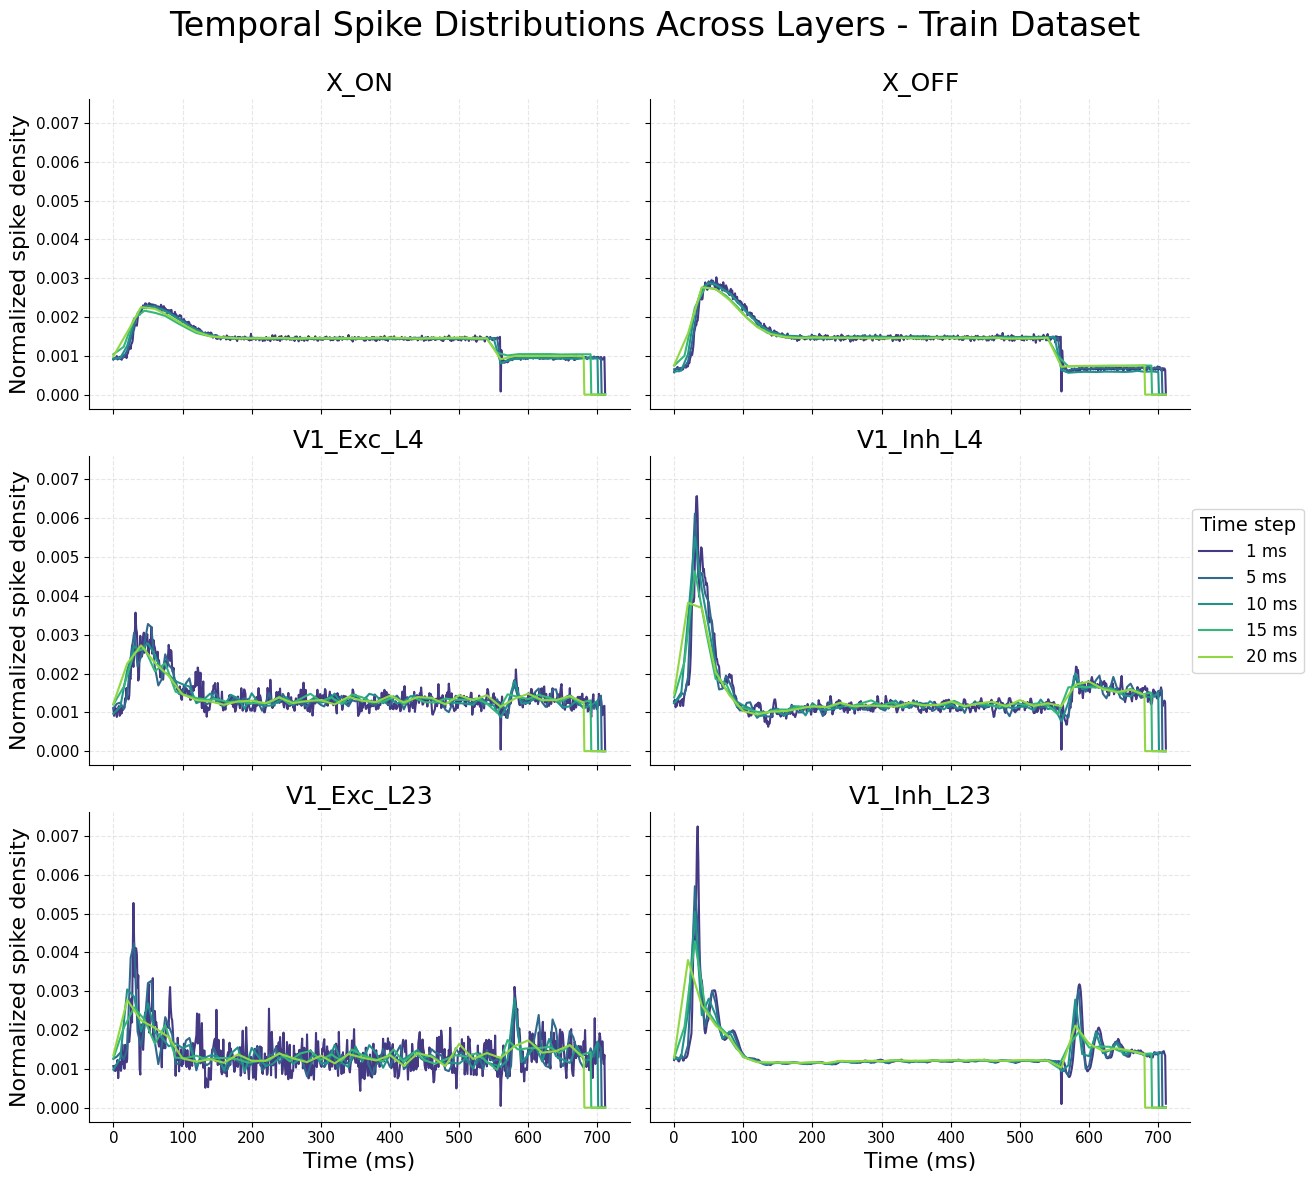

In [15]:
is_test = False
filename = f"temporal_spike_distribution_{"test" if is_test else "train"}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.TEMPORAL_SPIKE_DISTRIBUTION, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.TEMPORAL_SPIKE_DISTRIBUTION, save_fig=destination, is_test=is_test)

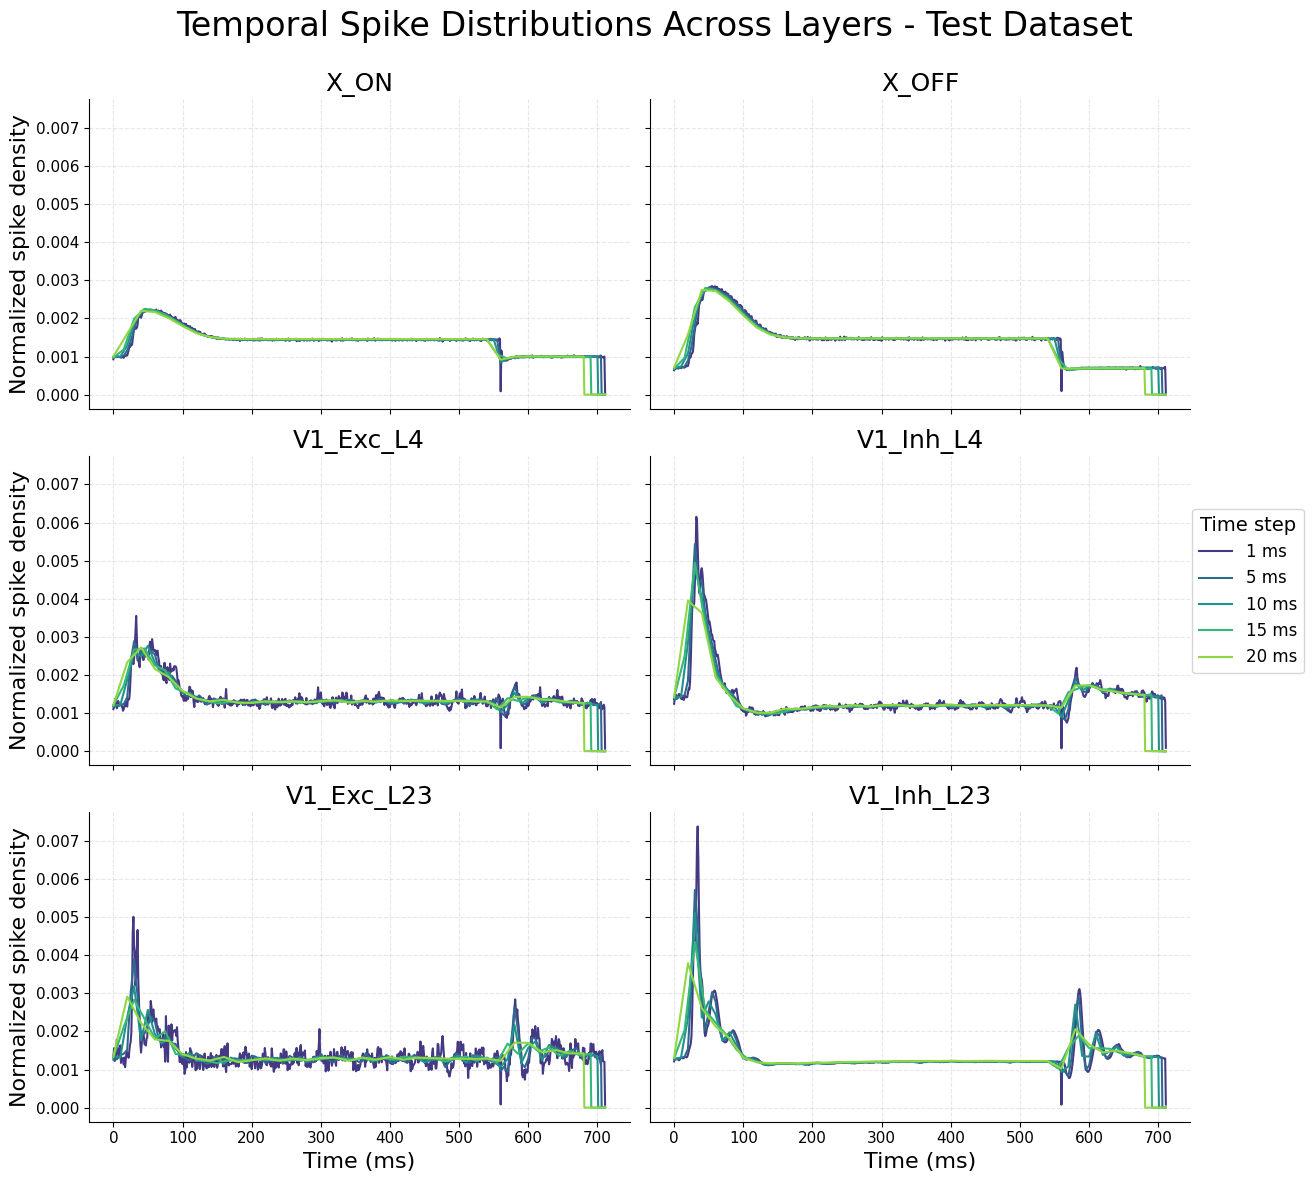

In [16]:
is_test = True
filename = f"temporal_spike_distribution_{"test" if is_test else "train"}.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
plot_data = result_analyzer.prepare_dataframe_for_plot(PlottingVariants.TEMPORAL_SPIKE_DISTRIBUTION, is_test=is_test)
ResultsPlotter.plot(plot_data, PlottingVariants.TEMPORAL_SPIKE_DISTRIBUTION, save_fig=destination, is_test=is_test)

/home/david/source/diplomka/results_analysis_tools/plotting/temporal_spike_distribution.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


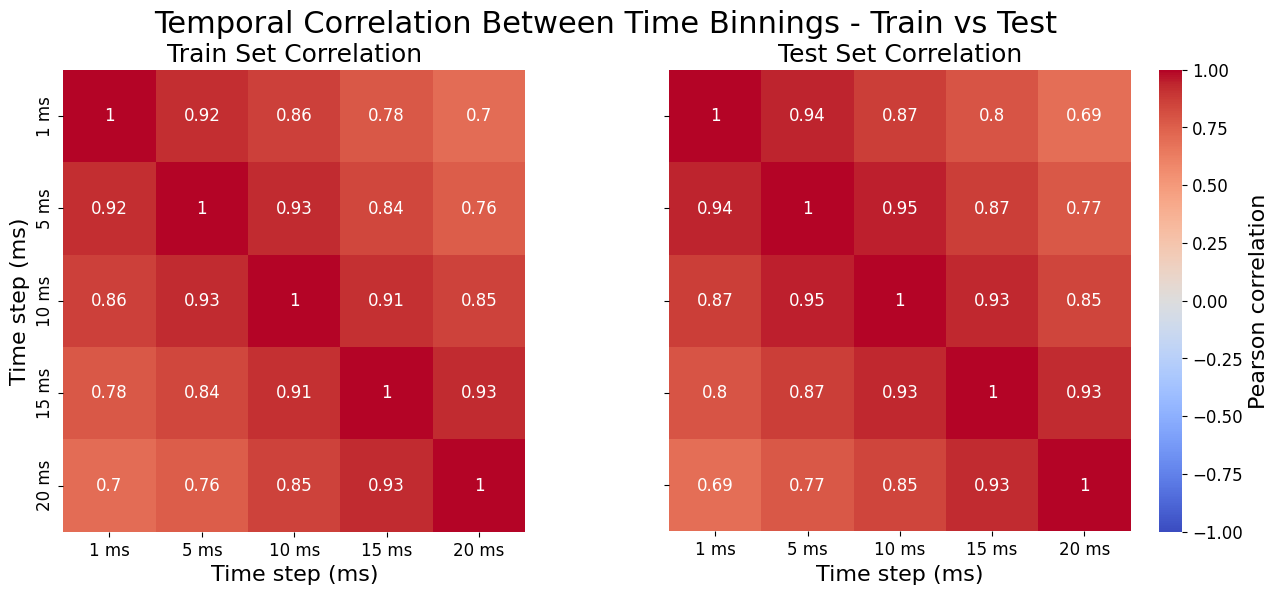

In [17]:
filename = "temporal_correlation_time_bin_size.pdf"
destination = f"{PLOTING_DESTINATION}{filename}"
train_corr = result_analyzer.dataset_time_binning_temporal_resolution_correlation_matrix(is_test=False)
test_corr = result_analyzer.dataset_time_binning_temporal_resolution_correlation_matrix(is_test=True)
ResultsPlotter.plot((train_corr, test_corr), PlottingVariants.CORRELATION_MATRIX_BIN_SIZE_TEMPORAL_DATASET, save_fig=destination, is_test=is_test)